**Notebook exemplifying outlier detection framework**

Structure of this workbook:
1. Setting-up the dependencies
2. Filter the databases for sectors/ set of activities that we want to compare
3. Choosing the methods we want to use in the comparison
4. Generate tables that hold total scores and input contributions to scores
5. Plotting the scores in a couple of ways characterized but also not characterized 

1. Dependencies - Imports and brightway setup

In [1]:
from functions_v2 import*

import brightway2 as bw
import bw2data as bd
import bw2analyzer as ba

#reduce?
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

*Setting up the brightway dependencies in terms of setting the project and loading the necessary databases (ecoinvent original, premise based ecoinvent)*

In [2]:
bd.projects.set_current("premise-validation-try1")
bw.bw2setup()

bio3=bw.Database('biosphere3')
ei39=bw.Database('ecoinvent 3.9.1 cutoff')
ei39SSP2=bw.Database('ei_cutoff_3.9_image_SSP2-RCP19_2050 2024-06-27')

Biosphere database already present!!! No setup is needed


2. Database Filters - Yaml filters and activties list

*load in file path to file and its name (.yaml) which contains defined sector filters*

In [7]:
print(os.getcwd())

c:\Users\fried\premise_validation\dev


In [3]:
fp_yaml='cement_concrete.yaml'

set_cement_concrete=generate_sets_from_filters(fp_yaml, database=ei39SSP2)


*generate_sets_from_filters function returns a dictionary of sectors as keys according to the .yaml file. Using list comprehension we generate a list of activities for one ore more of the sectors e.g. 'Cement'*

In [4]:
#List comprehension of yaml filtered sets to create activity list.
sector_cement=[x for x in set_cement_concrete['Cement']]

*Need to select the items from the list by splicing [:]. To reduce runtime, only 4 activities of the sector cement are selected. We could also further filter the secotr by a certain product type for instance Portland cement.*

In [5]:
#Activity list
sector_cement_small=sector_cement[:4]
sector_cement_small

['cement production, CP V RS' (kilogram, BR, None),
 'cement production, CEM II/B-S' (kilogram, ZA, None),
 'cement production, CEM III/A' (kilogram, CH, None),
 'cement production, CEM III/C' (kilogram, CH, None)]

3. Method - Get Methods, call bw.Method and store as variables in method list as well as in method dictionary.
(!This step needs to be polished: just one dictionary which is well structued is enough)

*Define method variables using the function find_and_create_method by defining certain method filters (or do it by hand)*

In [6]:
gwp=find_and_create_method(criteria=['IPCC', '2013', 'GWP100'], exclude=['no LT'])
gwp

Brightway2 Method: IPCC 2013: climate change: global warming potential (GWP100)

In [7]:
gwp.name[2]

'global warming potential (GWP100)'

In [8]:
energy_use=find_and_create_method(criteria=['EN15804','Cumulative', 'non-renewable' ])
energy_use

Brightway2 Method: EN15804: inventory indicators ISO21930: Cumulative Energy Demand - non-renewable energy resources

In [15]:
energy_use.name[2]

'Cumulative Energy Demand - non-renewable energy resources'

In [9]:
land_use=find_and_create_method(criteria=['land occupation','selected'])
land_use

Brightway2 Method: selected LCI results: resource: land occupation

In [10]:
water_use=find_and_create_method(criteria=['EN15804','fresh water'])
water_use

Brightway2 Method: EN15804: inventory indicators ISO21930: use of net fresh water

*store the method variables in a list for subsequent use*

In [10]:
meth_list=[gwp, energy_use, land_use, water_use]

In [11]:
meth_list

[Brightway2 Method: IPCC 2013: climate change: global warming potential (GWP100),
 Brightway2 Method: EN15804: inventory indicators ISO21930: Cumulative Energy Demand - non-renewable energy resources,
 Brightway2 Method: selected LCI results: resource: land occupation,
 Brightway2 Method: EN15804: inventory indicators ISO21930: use of net fresh water]

*Create a method dictionary for subsequent identification. The dictionary contains information on the method name and unit*

In [11]:
method_dict=create_method_dict(selected_methods_list=[gwp, energy_use, land_use, water_use])

#TBD:!?: Can I pick them automatically? via available bw.Methods in workbook? Function to give out the existing methods?

In [12]:
method_dict #check

{Brightway2 Method: IPCC 2013: climate change: global warming potential (GWP100): {'short name': 'global warming potential (GWP100)',
  'method name': "('IPCC 2013', 'climate change', 'global warming potential (GWP100)')",
  'method unit': 'kg CO2-Eq'},
 Brightway2 Method: EN15804: inventory indicators ISO21930: Cumulative Energy Demand - non-renewable energy resources: {'short name': 'Cumulative Energy Demand - non-renewable energy resources',
  'method name': "('EN15804', 'inventory indicators ISO21930', 'Cumulative Energy Demand - non-renewable energy resources')",
  'method unit': 'megajoule'},
 Brightway2 Method: selected LCI results: resource: land occupation: {'short name': 'land occupation',
  'method name': "('selected LCI results', 'resource', 'land occupation')",
  'method unit': 'square meter-year'},
 Brightway2 Method: EN15804: inventory indicators ISO21930: use of net fresh water: {'short name': 'use of net fresh water',
  'method name': "('EN15804', 'inventory indicators

5. Sector Scores Dataframes - Total Scores, Input Contribution Tables to Dataframe stored in list, save to excel too

*With the defined activity list and method list (or dict) we can now generate the dataframes containg the total score and input contributions from which we generate the plots. (Fyi: This step can take a while)*

In [13]:
cement_sector_compare=compare_activities_multiple_methods(
    activities_list=sector_cement_small, 
    methods=method_dict,  
    identifier='cement',
    output_format='pandas',
    mode='absolute')

Omitting activity name common prefix: 'cement production, '
Omitting activity name common prefix: 'cement production, '
Omitting activity name common prefix: 'cement production, '
Omitting activity name common prefix: 'cement production, '


In [14]:
cement_sector_compare

{'cement_ipcc_2013_climate_change_global_warming_potential_(gwp100)':      activity    product location      unit  \
 0  CEM II/B-S  EM II/B-S       ZA  kilogram   
 1   CEM III/A   EM III/A       CH  kilogram   
 2   CEM III/C   EM III/C       CH  kilogram   
 3     CP V RS     P V RS       BR  kilogram   
 
                               method method unit     total  direct emissions  \
 0  global warming potential (GWP100)   kg CO2-Eq  0.614891               0.0   
 1  global warming potential (GWP100)   kg CO2-Eq  0.420014               0.0   
 2  global warming potential (GWP100)   kg CO2-Eq  0.155533               0.0   
 3  global warming potential (GWP100)   kg CO2-Eq  0.703074               0.0   
 
    37430: Cement clinkers  \
 0                0.519065   
 1                0.364828   
 2                0.088434   
 3                0.626334   
 
    37440: Portland cement, aluminous cement, slag cement and similar hydraulic cements, except in the form of clinkers  \
 0     

In [18]:
list(cement_sector_compare.keys())[:] #getting name of the dataframe which holds gwp method scores

['cement_ipcc_2013_climate_change_global_warming_potential_(gwp100)',
 'cement_en15804_inventory_indicators_iso21930_cumulative_energy_demand_-_non-renewable_energy_resources',
 'cement_selected_lci_results_resource_land_occupation',
 'cement_en15804_inventory_indicators_iso21930_use_of_net_fresh_water']

*Manipulate the output a little using small_inputs_to_other_column reducing the size of the dataframe by neglecting the inputs that contribute 0.01 or less to the overall score of an activity/dataset*

In [16]:
cement_sector_compare=small_inputs_to_other_column(cement_sector_compare, cutoff = 0.02)
cement_sector_compare

{'cement_ipcc_2013_climate_change_global_warming_potential_(gwp100)':      activity    product location      unit  \
 3     CP V RS     P V RS       BR  kilogram   
 0  CEM II/B-S  EM II/B-S       ZA  kilogram   
 1   CEM III/A   EM III/A       CH  kilogram   
 2   CEM III/C   EM III/C       CH  kilogram   
 
                               method method unit     total  \
 3  global warming potential (GWP100)   kg CO2-Eq  0.703074   
 0  global warming potential (GWP100)   kg CO2-Eq  0.614891   
 1  global warming potential (GWP100)   kg CO2-Eq  0.420014   
 2  global warming potential (GWP100)   kg CO2-Eq  0.155533   
 
    37430: Cement clinkers  \
 3                0.626334   
 0                0.519065   
 1                0.364828   
 2                0.088434   
 
    37440: Portland cement, aluminous cement, slag cement and similar hydraulic cements, except in the form of clinkers  \
 3                                           0.000000                                            

3. Plotting

3.1. Level 1 dot plots

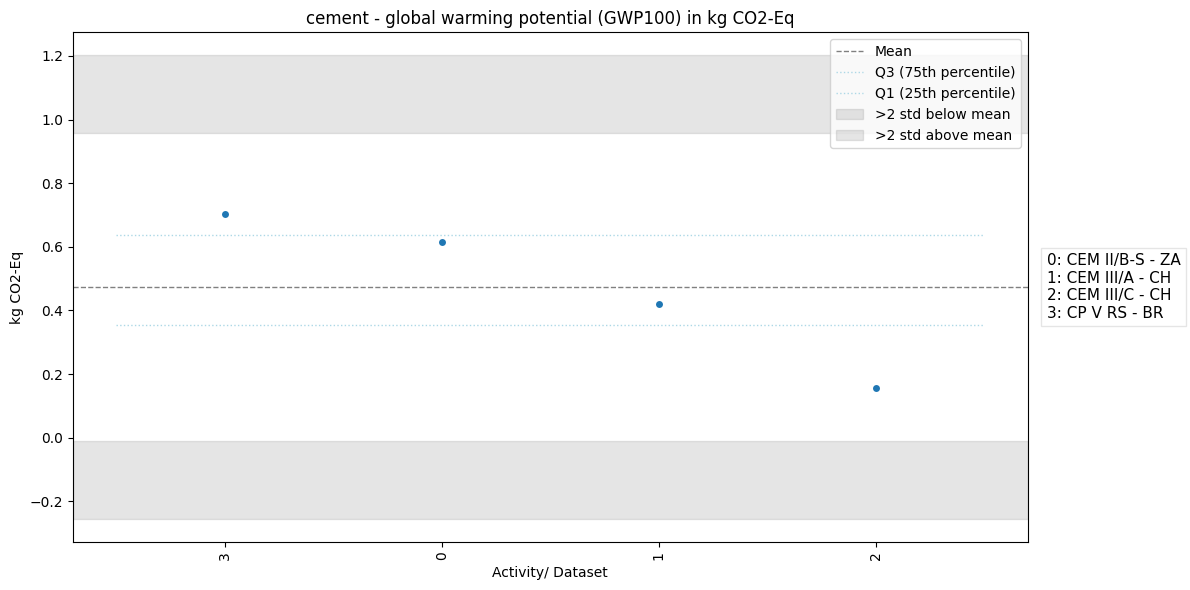

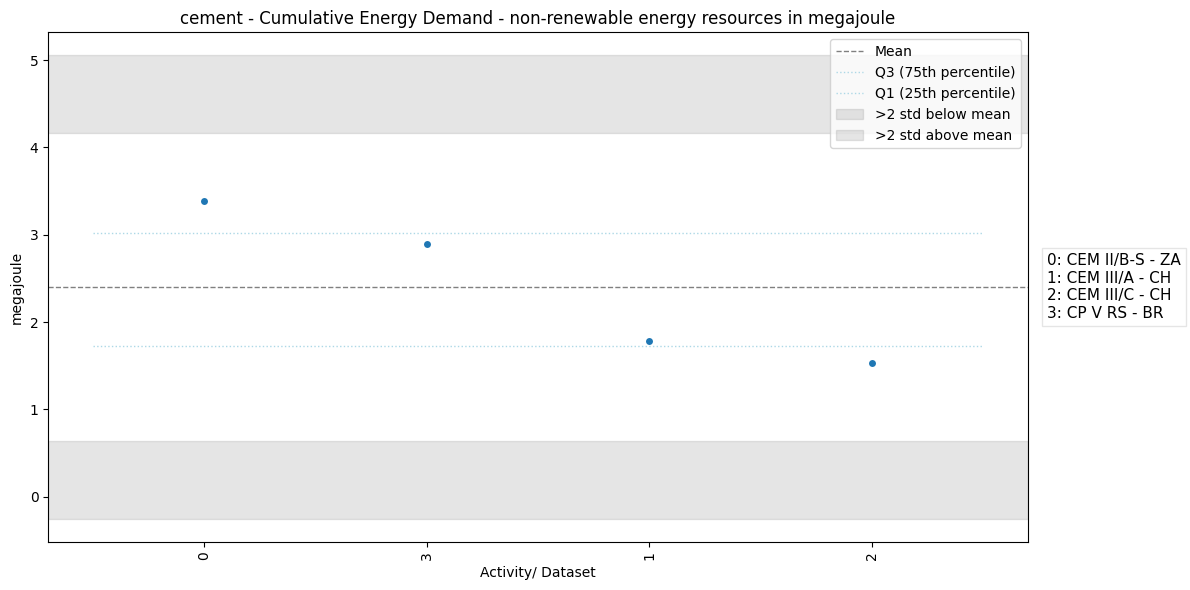

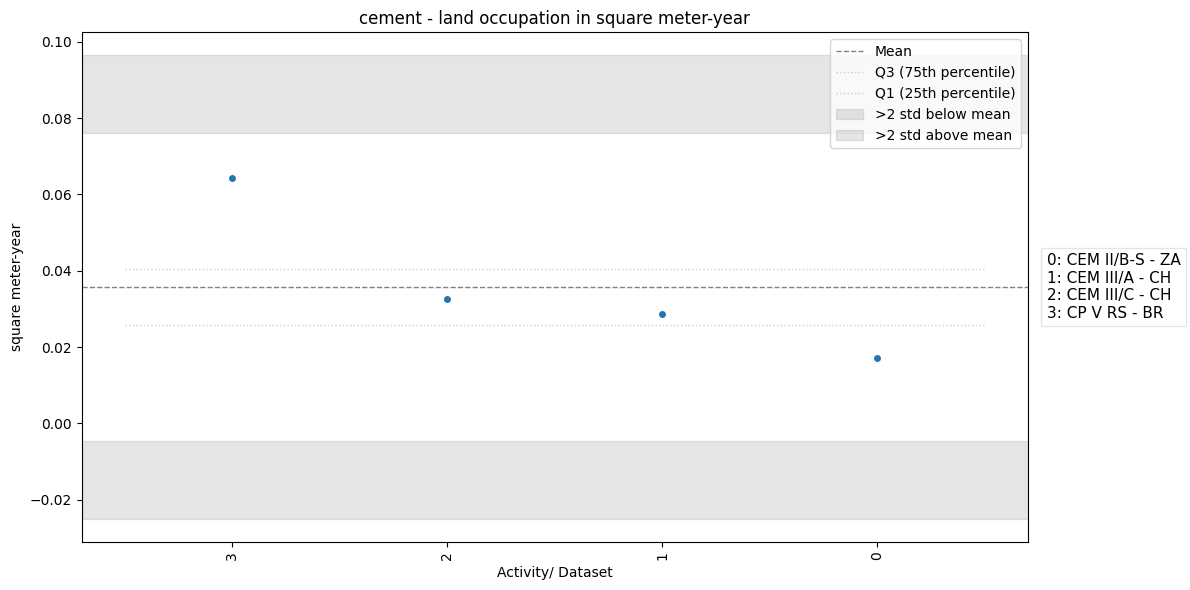

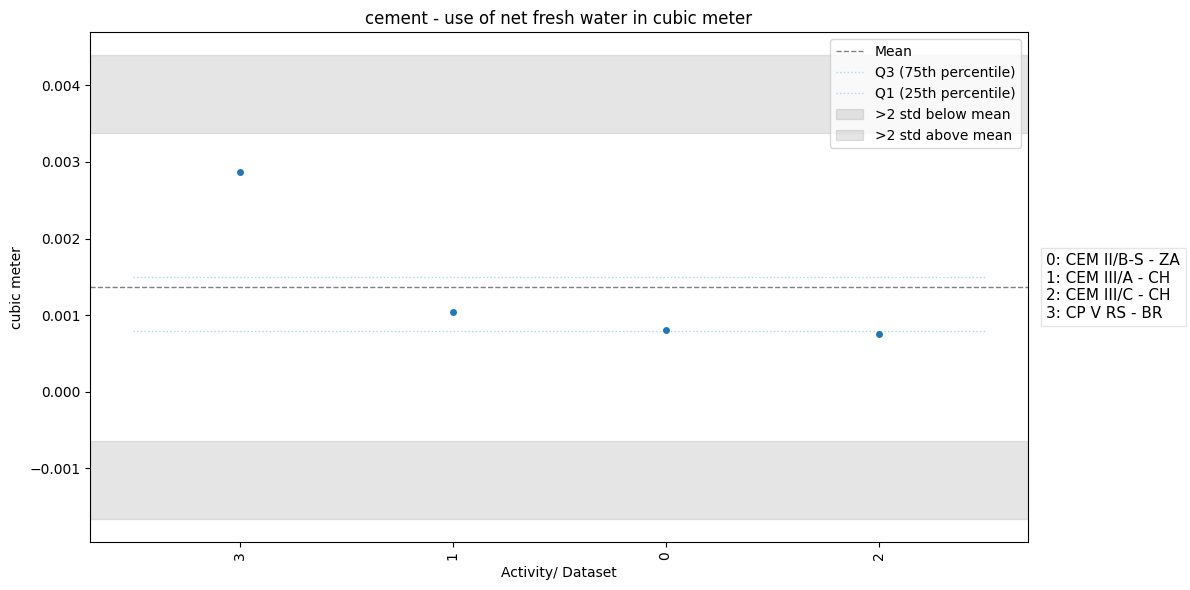

In [17]:
lvl1_plot(cement_sector_compare, 'cement')

3.2. Level 2.1 stacked absolute bar plots

*TBD: Color palette is not so nice (too alike colors are misleading), Y-axis units not showing*

In [28]:
def lvl21_plot_stacked_absolute(dataframes_dict, title_key=None):
    '''
    Comparing activities and the input contributions to the total score by plotting a stacked absolute bar plot for each method.

    :param dataframes_dict: dictionary resulting from the function "compare_activities_multiple_methods" (and subsequently "small_inputs_to_other_column")
    :param title_key: some string for the plot titles
    '''
    # Step 1: Collect all unique categories
    all_categories = set()
   
    for df in dataframes_dict.values():
        if 'total' in df.columns:
            total_index = df.columns.get_loc('total')
            relevant_columns = df.columns[total_index + 1:]
        else:
            relevant_columns = df.columns
       
        # Update all_categories set with relevant columns
        all_categories.update(relevant_columns)
   
    all_categories = list(all_categories)
   
    # Step 2: Create a consistent color palette and color map
    distinct_colors = generate_distinct_colors(len(all_categories))
    color_map = dict(zip(all_categories, distinct_colors))

    # Step 3: Plot each DataFrame
    for key, df in dataframes_dict.items():
        if 'total' in df.columns:
            df_og = df.copy() #for calling method and informative column in title and axis
            total_index = df.columns.get_loc('total')
            df = df.iloc[:, total_index + 1:]
       
        # Create a new figure for each plot
        fig, ax = plt.subplots(figsize=(20, 10))
       
        # Ensure columns match the categories used in the color map
        df = df[[col for col in df.columns if col in color_map]]
        
        # Plotting the DataFrame with the custom color map
        df.plot(kind='bar', stacked=True, ax=ax, color=[color_map[col] for col in df.columns])

        # Add titles and labels
        ax.set_title(f"{str(title_key)} - {df_og['method'].iloc[0]} in {df_og['method unit'].iloc[0]}")
        ax.set_xlabel('Activity/ Dataset')
        ax.set_ylabel(f"{df_og['method unit'].iloc[0]}")
        
        # First legend: Categories
        first_legend = ax.legend(title='Categories', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
        
        # Add the first legend manually
        ax.add_artist(first_legend)
        
        # Generate the legend text using the first dataframe
        legend_text = generate_legend_text(dataframes_dict)
        
        # Create a second legend below the first one
        fig.text(1.02, 0.1, '\n'.join(legend_text), transform=ax.transAxes, fontsize=11, 
                 verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.2, edgecolor='grey'))
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=90, ha='right')
       
        # Adjust layout to make room for both legends
        plt.tight_layout()
        plt.subplots_adjust(right=0.75, bottom=0.2)
       
        # Display the plot
        plt.show()

In [21]:
cement_sector_compare['method name'].iloc[0]

KeyError: 'method name'

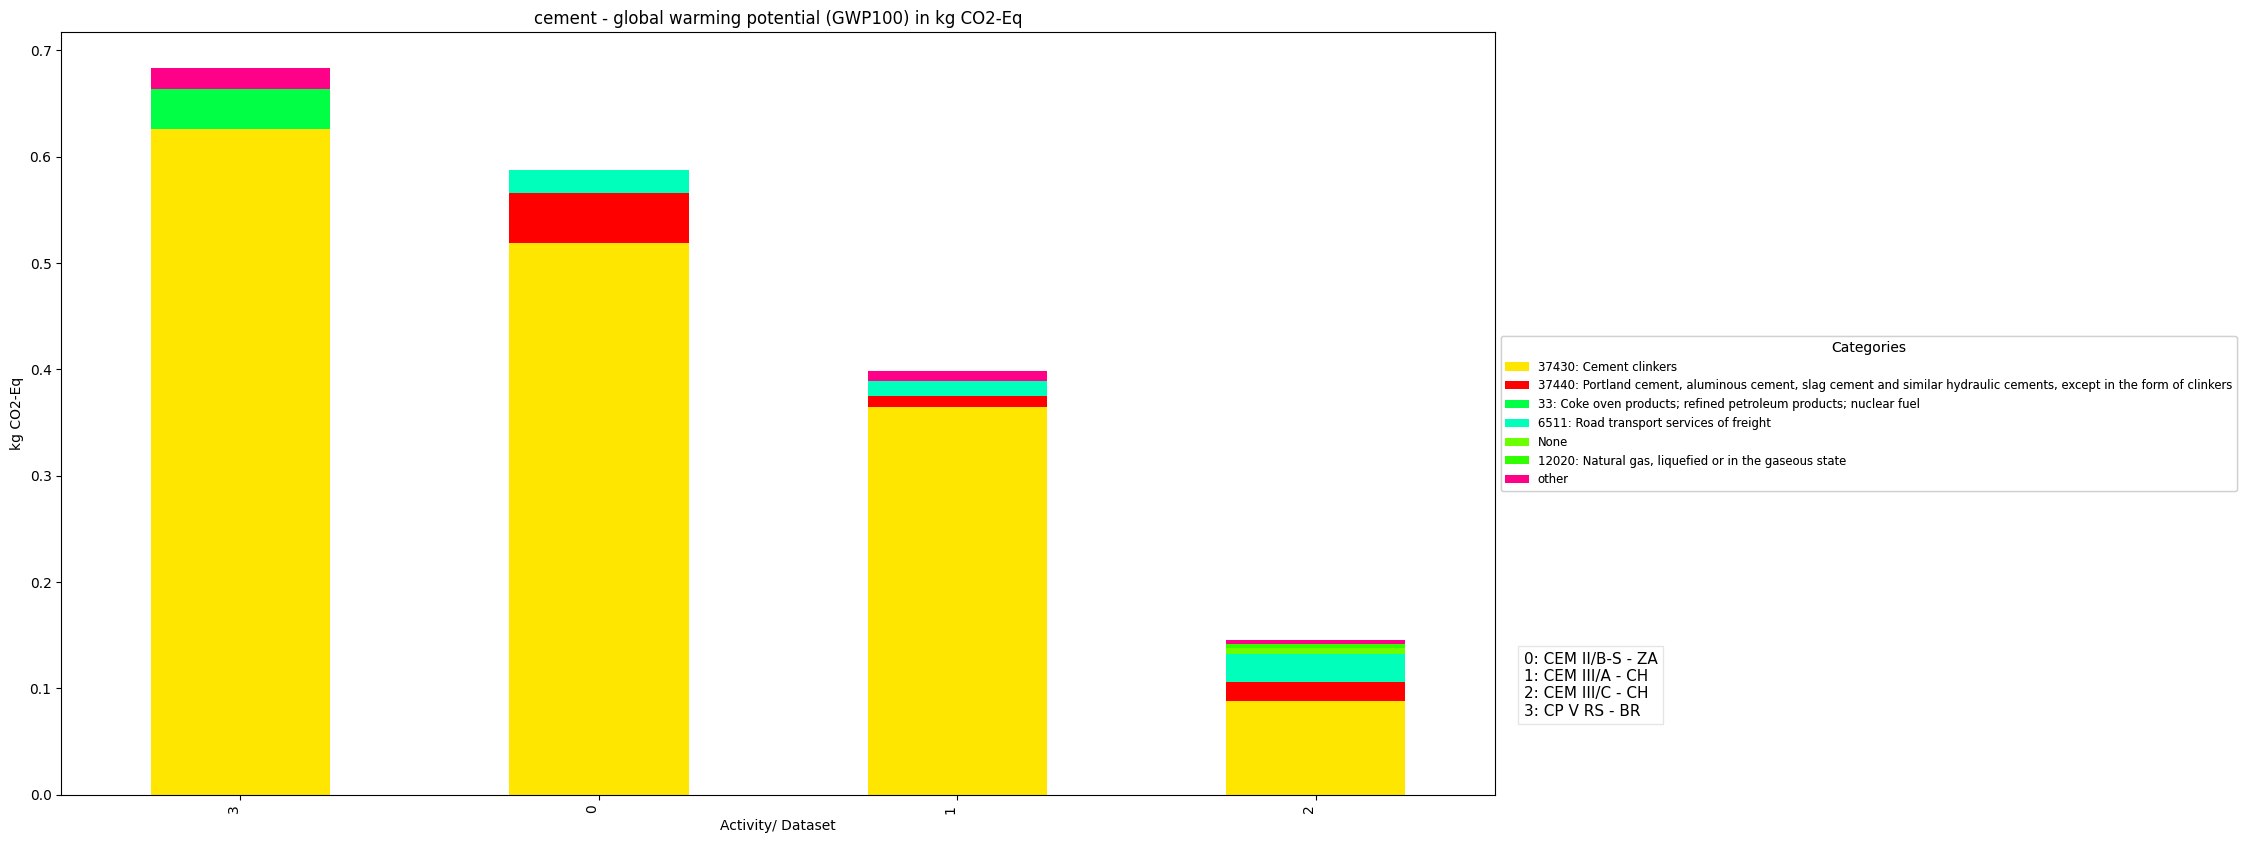

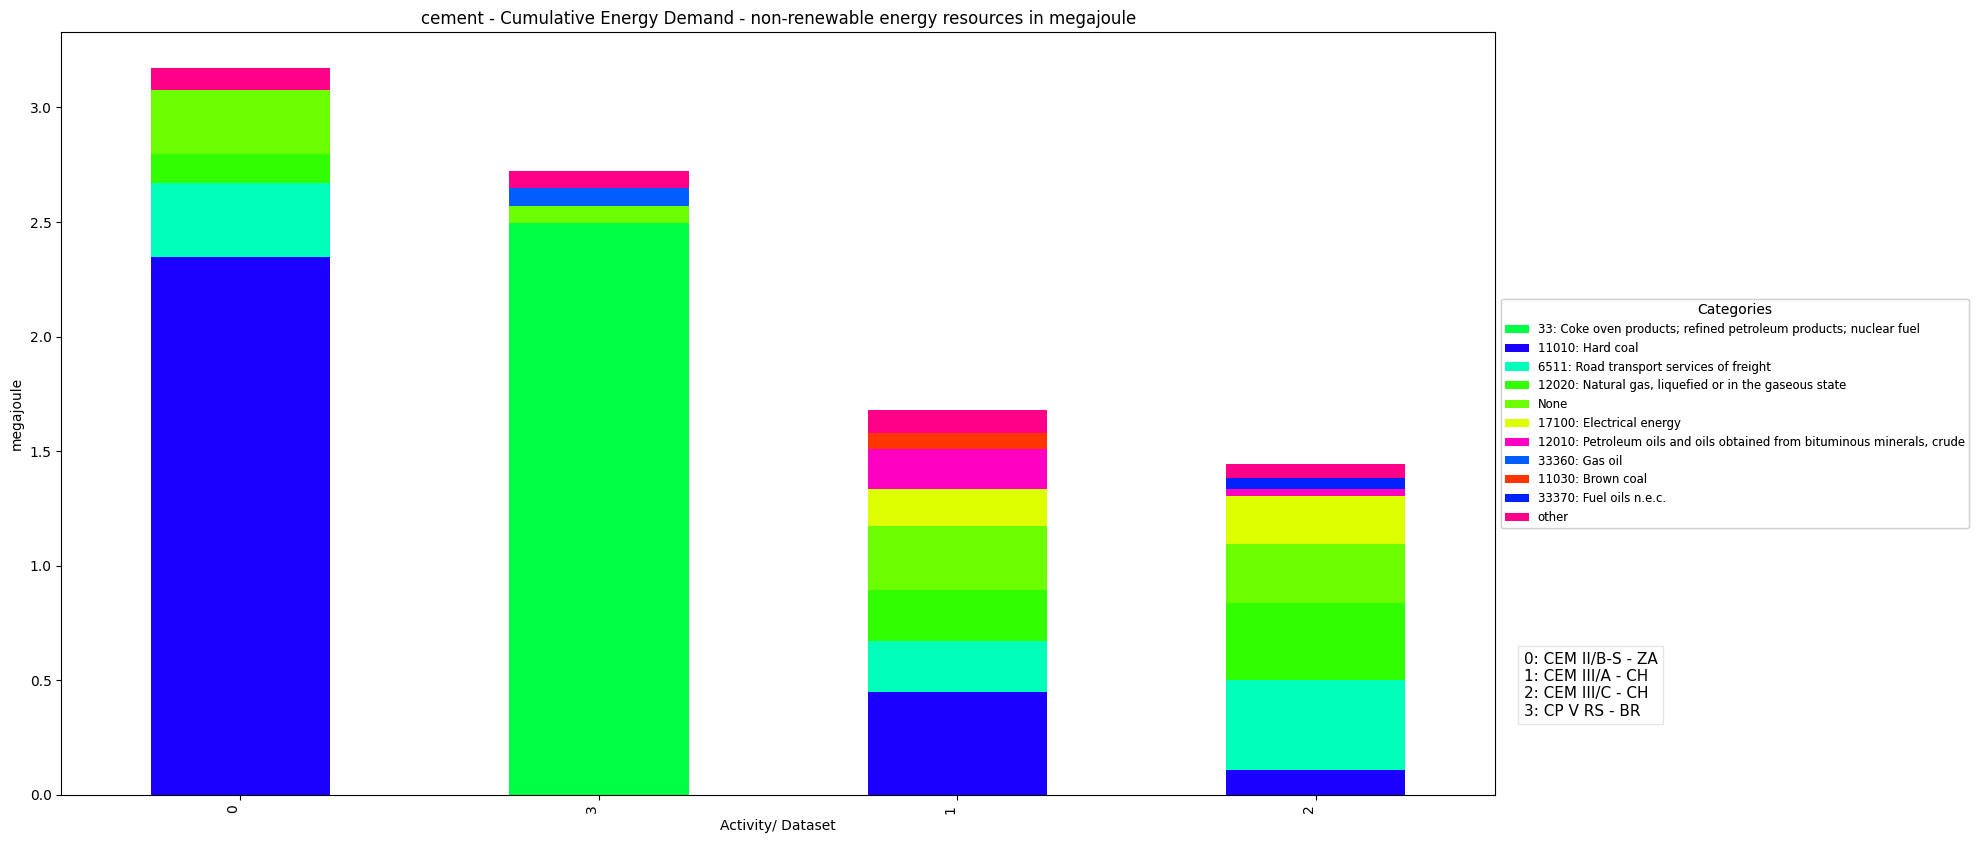

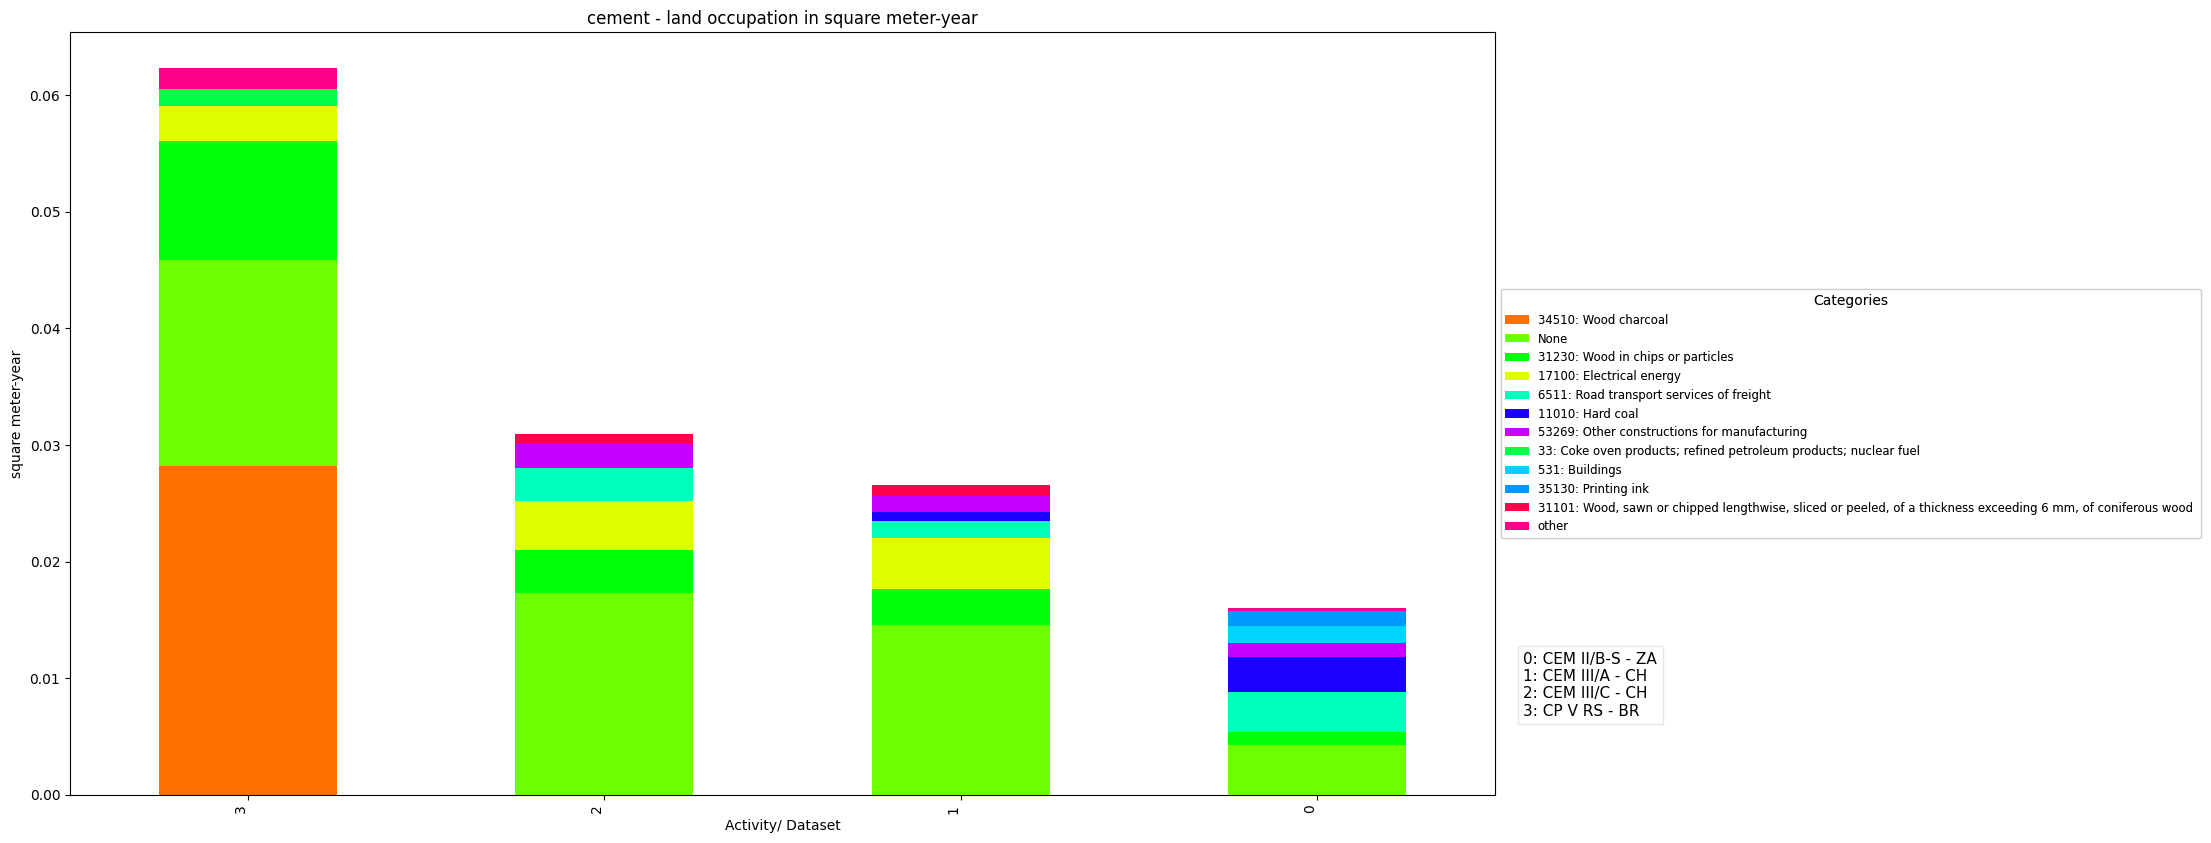

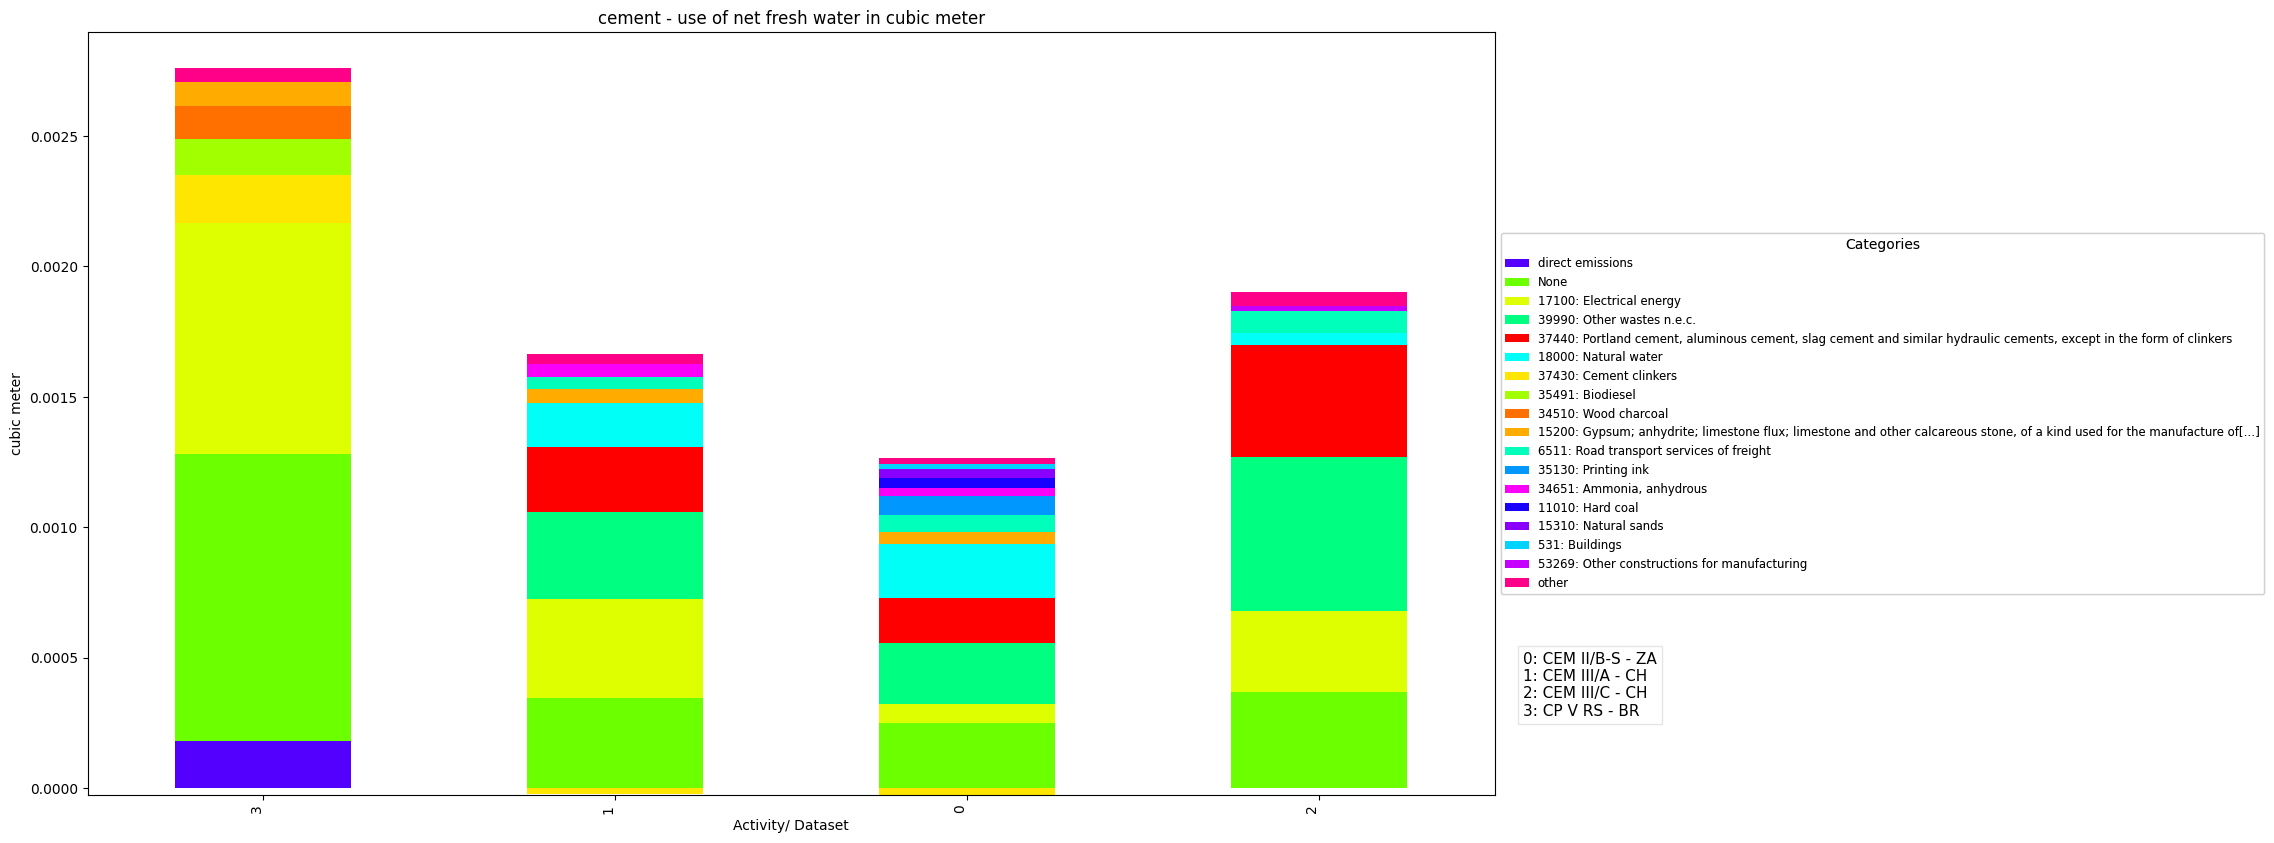

In [29]:
lvl21_plot_stacked_absolute(cement_sector_compare, 'cement')

3.3. Level 2.2 Bar plots of a certain characterized input compared among datasets/ activities

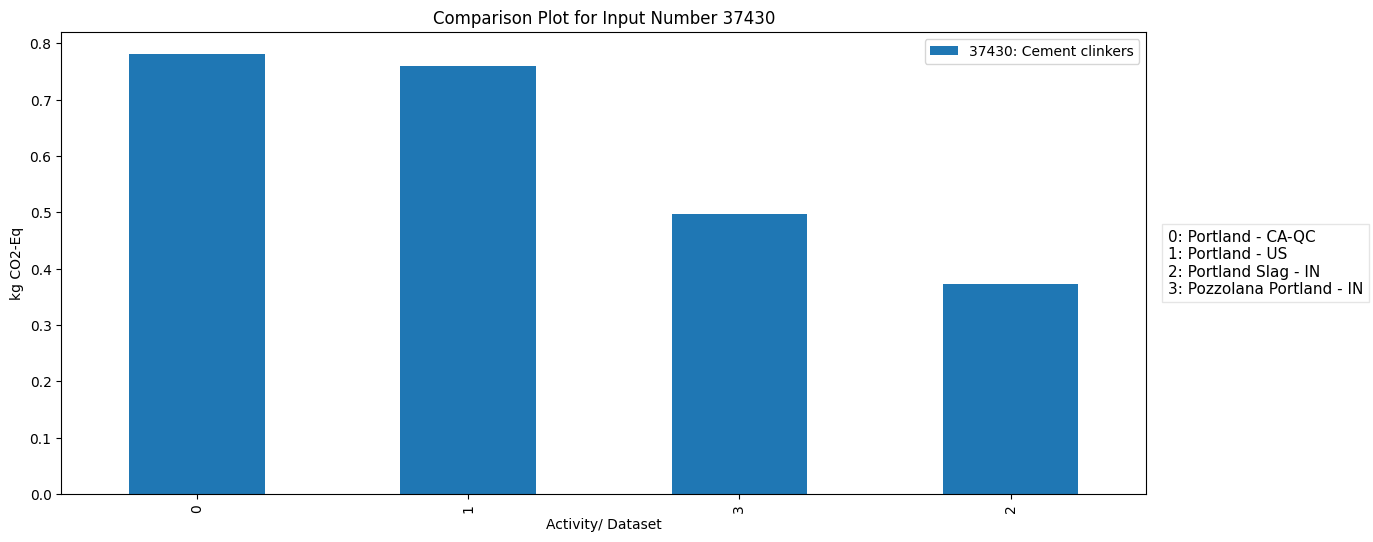

In [20]:
lvl22_plot_input_comparison_with_method(cement_sector_compare, 'cement_ipcc_2013_climate_change_global_warming_potential_(gwp100)', '37430')

3.3. Level 2.3 Bar plots of a certain input not characterized

*TBD: Include same legend as in previous graph which shows the name of the input*

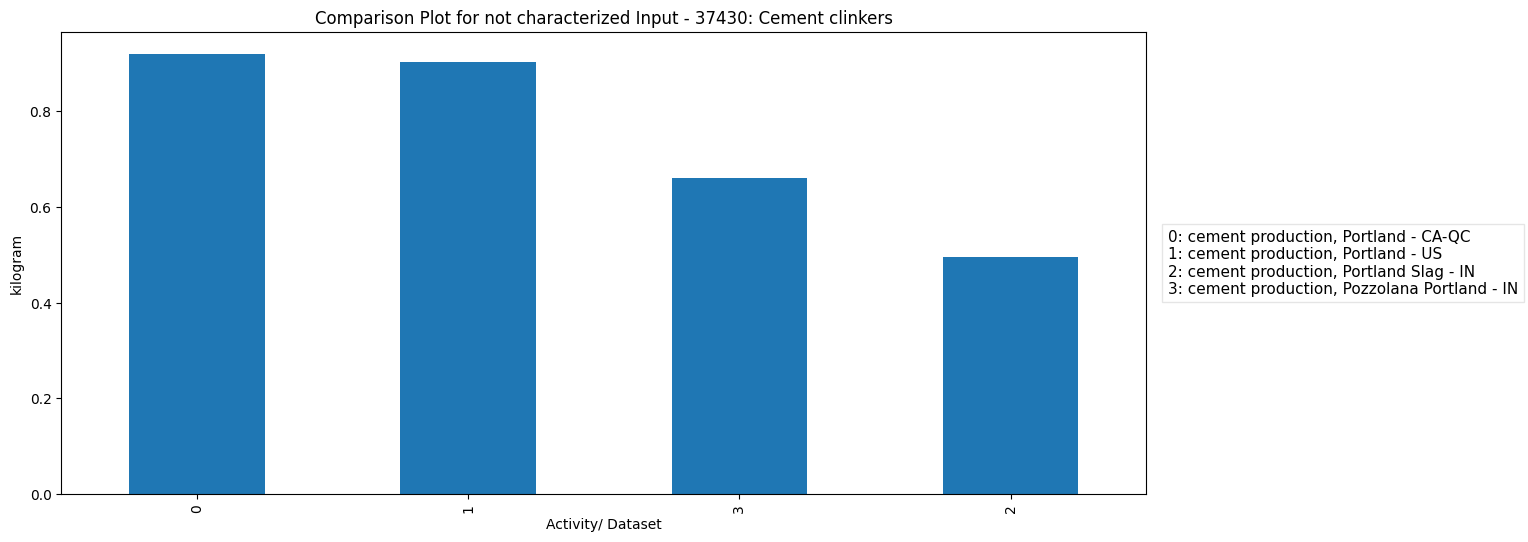

In [21]:
lvl23_plot_input_comparison_plot_no_method(sector_cement_small, input_type='list', input_number='37430')

3.4. Level 3 S-curve

*Need to generate a set of activities from the ecoinvent database which matches that of the premise based database. A small selection of cement datasets is made, to reduce runtime*

*TBD: Need to include treatment of activities which are only present in premise but not in ecoinvent*

In [22]:
set_cement_concrete_ei39=generate_sets_from_filters(fp_yaml, database=ei39)

In [23]:
small_set_cement_ei39=[x for x in set_cement_concrete_ei39['Cement'] if 'Portland' in str(x)]
small_set_cement_ei39

['cement production, Portland' (kilogram, RoW, None),
 'cement production, Portland' (kilogram, IN, None),
 'cement production, Portland' (kilogram, PE, None),
 'cement production, Portland' (kilogram, CA-QC, None),
 'cement production, Portland Slag' (kilogram, IN, None),
 'cement production, Portland' (kilogram, US, None),
 'cement production, Pozzolana Portland' (kilogram, IN, None),
 'cement production, Portland' (kilogram, BR, None),
 'cement production, Portland' (kilogram, CH, None),
 'cement production, Portland' (kilogram, Europe without Switzerland, None),
 'cement production, Portland' (kilogram, ZA, None)]

In [24]:
small_set_cement_ei39SSP2=[x for x in set_cement_concrete['Cement'] if 'Portland' in str(x)]
small_set_cement_ei39SSP2

['cement production, Portland' (kilogram, CA-QC, None),
 'cement production, Portland' (kilogram, US, None),
 'cement production, Pozzolana Portland' (kilogram, IN, None),
 'cement production, Portland Slag' (kilogram, IN, None),
 'cement production, Portland' (kilogram, BR, None),
 'cement production, Portland' (kilogram, Europe without Switzerland, None),
 'cement production, Portland' (kilogram, CH, None),
 'cement production, Portland' (kilogram, ZA, None),
 'cement production, Portland' (kilogram, RoW, None),
 'cement production, Portland' (kilogram, IN, None),
 'cement production, Portland' (kilogram, PE, None)]

method: ('EN15804', 'inventory indicators ISO21930', 'Cumulative Energy Demand - non-renewable energy resources')
('cement production, Portland', 'kilogram', 'RoW', 'cement, Portland'): -0.16959422042277536
('cement production, Portland', 'kilogram', 'IN', 'cement, Portland'): -0.25164372778778993
('cement production, Portland', 'kilogram', 'PE', 'cement, Portland'): -0.0804718407851663
('cement production, Portland', 'kilogram', 'CA-QC', 'cement, Portland'): 0.0011289636388264429
('cement production, Portland Slag', 'kilogram', 'IN', 'cement, Portland Slag'): -0.31517898241979864
('cement production, Portland', 'kilogram', 'US', 'cement, Portland'): -0.25736953077710994
('cement production, Pozzolana Portland', 'kilogram', 'IN', 'cement, Pozzolana Portland'): -0.25952148057218843
('cement production, Portland', 'kilogram', 'BR', 'cement, Portland'): -0.05189055484939185
('cement production, Portland', 'kilogram', 'CH', 'cement, Portland'): -0.06673179405747044
('cement production, Por

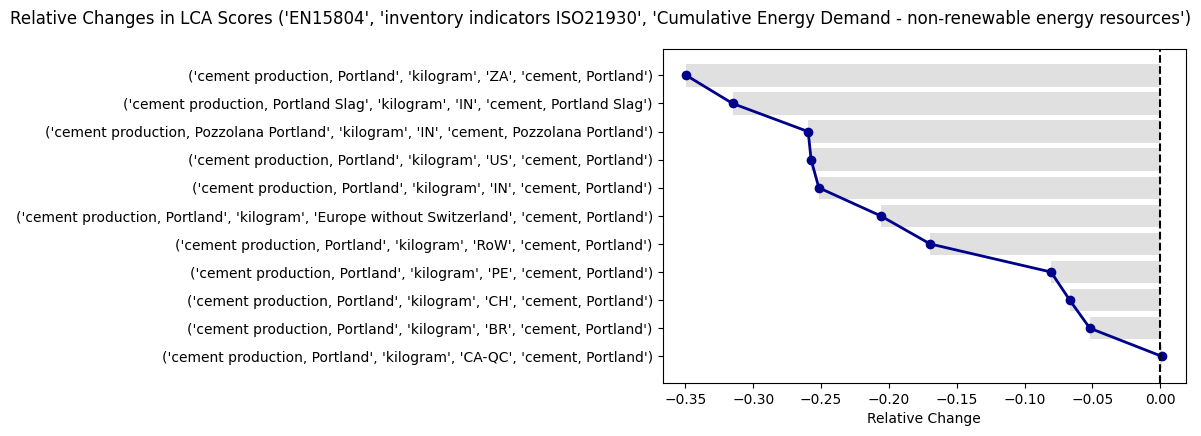

In [25]:
lvl3_plot_relative_changes(small_set_cement_ei39, small_set_cement_ei39SSP2, method=meth_list[1].name)

*TBD: 1. Test with other sectors, larger activity lists. 2. Check water use results*